# Project-1 Live demo

## Step-0: Setup

In [76]:
import gc #garbage collector
import os
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets.sleep_physionet.age import fetch_data
from collections import Counter
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import shuffle
import h5py
from torch.utils.data import Dataset, ConcatDataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import LeavePGroupsOut
from torch.utils.data import ConcatDataset
import torch
import joblib


# Classification tools
from sklearn.metrics import accuracy_score
from scipy.signal import welch
from scipy.stats import entropy
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import nolds 
from scipy.signal import detrend

## nn tools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
import copy
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

import tkinter as tk
from tkinter import filedialog

%matplotlib inline
mne.set_log_level('ERROR')  # To avoid flooding the cell outputs with messages

In [44]:
# Identify whether a CUDA-enabled GPU is available
import torch

if torch.cuda.is_available():
    print('CUDA-enabled GPU found. Training should be faster.')
else:
    print('No GPU found. Training will be carried out on CPU, which might be '
          'slower.\n')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

No GPU found. Training will be carried out on CPU, which might be slower.



## Step-1: Select file to predict

### Hand pick file

In [45]:
# Funzione per aprire il file explorer e filtrare i file
def open_file_explorer():
    root = tk.Tk()
    root.withdraw()  # Nascondi la finestra principale di Tkinter
    file_path = filedialog.askopenfilename(
        initialdir='sleep-telemetry',
        title='Seleziona un file',
        filetypes=[('Hypnogram files', '*-PSG*')]
    )
    return file_path

# Salva il file selezionato in una variabile
psg_file = open_file_explorer()

In [46]:
psg_file = psg_file.split('/')[-1]

### Find correspondind Hypnogram file

In [47]:
hypnogram_file = ""
data_dir = "./sleep-telemetry"

# List all PSG and Hypnogram files
edf_files = [f for f in os.listdir(data_dir) if f.endswith('.edf')]
hypnogram_files = [f for f in edf_files if '-Hypnogram' in f]

subject_night = psg_file.split('J0-PSG')[0]  # Extract subject and night (e.g., ST7ssNJ0)
for hypno_file in hypnogram_files:
    if subject_night in hypno_file:
        hypnogram_file = hypno_file
        break

In [48]:
print(f'Seleted Hypnogram file: {hypnogram_file}')
print(f'PSG file: {psg_file}')

Seleted Hypnogram file: ST7021JM-Hypnogram.edf
PSG file: ST7021J0-PSG.edf


## Step 2: Apply live transformations

### Convert to hypnogram data format

After a quick research on the web those are the infrormations that arise about each of the 5 channels of our EEG:

1. **EEG Fpz-Cz**: This is a standard EEG channel that records brain activity. $\to$ 
we keep it as an EEG channel as it could be important to learn on

2. **EEG Pz-Oz**: Another standard EEG channel. $\to$ 
we keep it as an EEG channel as it could be important to learn on

3. **EOG horizontal**: Electrooculography (EOG) is used to monitor eye movements. Eye movements are crucial for detecting REM sleep $\to$ 
we keep it as an EEG channel as it is very clearly much important to learn on (in our use-case)

4. **EMG submental**: Electromyography (EMG) from submental (chin) muscles. Submental EMG is vital for detecting muscle tone, which helps differentiate between REM sleep (low muscle tone) and other stages $\to$ 
apparently this channel is useful too to analyze sleep stages

5. **Marker**: Typically used for event markers or annotations. $\to$ we can scrap this channel

therefore we create this mapping dictionary to assign to 'misc' all usless channels:

In [49]:
def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True, 
                             crop_wake_mins=30):
    
    # Mapping of channel names to types that we want to delete
    mapping = {'Marker': 'misc',
            'Resp oro-nasal': 'misc',  # not present in our case
            'Temp rectal': 'misc' } # not present in our case
    
    exclude = mapping.keys() if load_eeg_only else ()

    # Load raw data and annotations
    original_fname = raw_fname
    raw_fname = os.path.join(data_dir, raw_fname)
    annot_fname = os.path.join(data_dir, annot_fname)
    
    raw = mne.io.read_raw_edf(raw_fname, exclude=exclude)
    annots = mne.read_annotations(annot_fname)
    raw.set_annotations(annots, emit_warning=False)
    if not load_eeg_only:
        raw.set_channel_types(mapping)
    
    if crop_wake_mins > 0:  # Cut start and end Wake periods
        # Find first and last sleep stages
        mask = [x[-1] in ['1', '2', '3', '4', 'R'] 
                for x in annots.description]
        sleep_event_inds = np.where(mask)[0]

        # Crop raw
        tmin = max(0, annots[int(sleep_event_inds[0])]['onset'] - crop_wake_mins * 60)
        tmax = min(raw.times[-1], annots[int(sleep_event_inds[-1])]['onset'] + crop_wake_mins * 60)
        raw.crop(tmin=tmin, tmax=tmax)
    
    # Rename EEG channels
    ch_names = {i: i.replace('EEG ', '') 
                for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)
    
    # Save subject and recording night information in raw.info
    basename = os.path.basename(original_fname)
    subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
    concat = f'{subj_nb}{rec_nb}' 

    raw.info['subject_info'] = {'id': int(concat) }
   
    return raw

In [50]:
# Load recordings
example_file = load_sleep_physionet_raw(psg_file, hypnogram_file)
sfreq = example_file.info['sfreq']  # Sampling frequency
n_channels = example_file.info['nchan']  # Number of channel

# Display basic information about the recording
example_file.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fpz-Cz, Pz-Oz, EOG horizontal, EMG submental
 chs: 4 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 800.0 Hz
 meas_date: 1994-09-19 00:00:30 UTC
 nchan: 4
 projs: []
 sfreq: 100.0 Hz
 subject_info: <subject_info | id: 21>
>

### Explore signal properties

Signal:

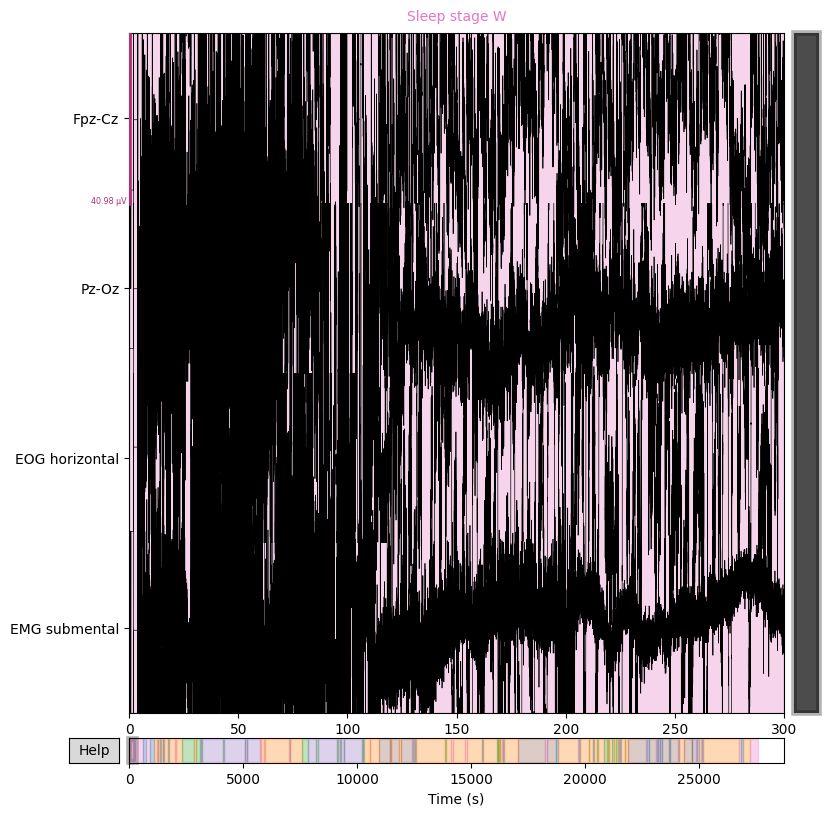

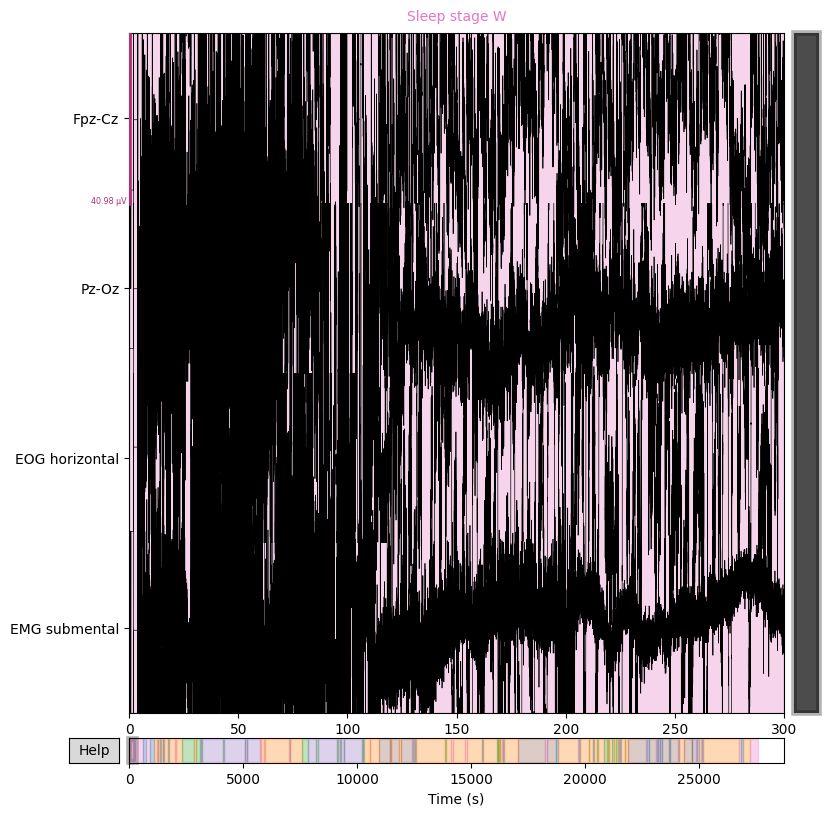

In [51]:
# Plot raw EEG data (for visualization)
example_file.plot(duration=300, n_channels=4, scalings='auto')

Labels:

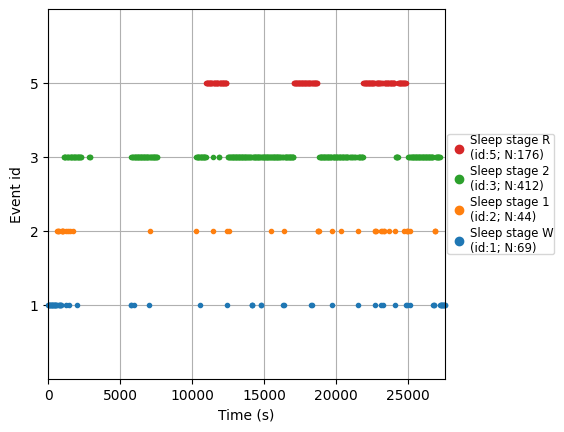

In [52]:
events, event_id_for_plot = mne.events_from_annotations(
        example_file, event_id={
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3/4': 4,  # Combined stage 3 and 4
        'Sleep stage R': 5
        }, 
        chunk_duration=30., verbose=False)

# plot events
mne.viz.plot_events(events, event_id=event_id_for_plot, sfreq=example_file.info['sfreq'])

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Filter signal

Following a brief online search, it was determined that the most relevant information in sleep EEG data resides below 30 Hz. To reduce the influence of higher-frequency noise, we apply a low-pass filter with a cutoff frequency of 30 Hz to our recordings.

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


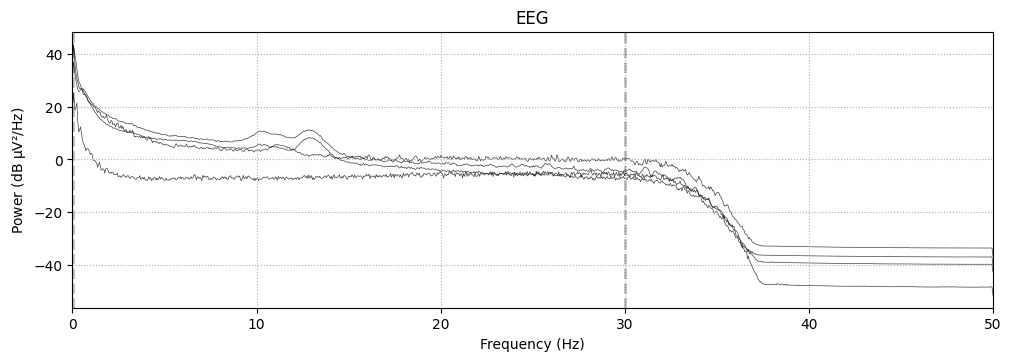

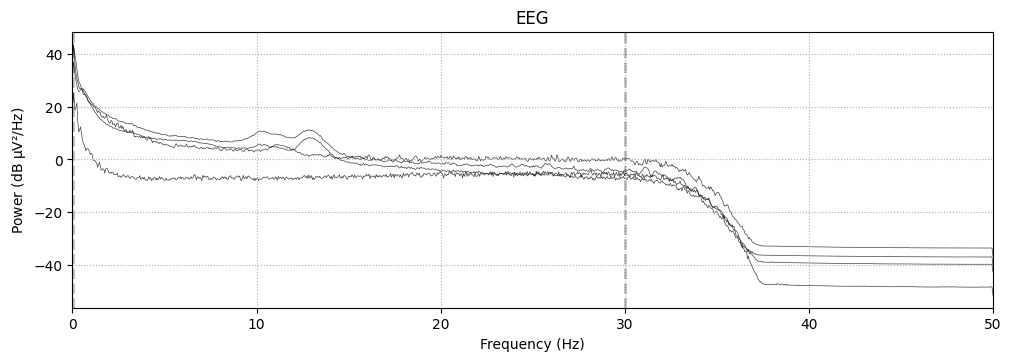

In [53]:
bottom_freq, top_freq = None, 30

example_file.load_data().filter(bottom_freq, top_freq)  # filter data locally

example_file.plot_psd()

### Extract epochs

We can now proceed to extract epochs. Wich just means creating 30 seconds long samples (and respective label of sleep stage) from our recordings so that we can later use those to define out train / validation / test sets.

Also we prepare this this dictionary to classify events of each recording into 4 sleep stages classes (we merge class 3 and 4 for convenience):

In [54]:
expected_stages = {
    'Sleep stage W': 1,  # Wake
    'Sleep stage 1': 2,  # NREM 1
    'Sleep stage 2': 3,  # NREM 2
    'Sleep stage 3': 4,  # NREM 3
    'Sleep stage 4': 4,  # Combine stage 3 and 4 (deep sleep)
    'Sleep stage R': 5   # REM sleep
}

# Create a new event_id that unifies stages 3 and 4
event_id = {
    'Sleep stage W': 1,
    'Sleep stage 1': 2,
    'Sleep stage 2': 3,
    'Sleep stage 3/4': 4,  # Combined stage 3 and 4
    'Sleep stage R': 5
}

Then we can proceed to define a function to extract epochs from our recordings:

In [55]:
def extract_epochs(raw, chunk_duration=30.):
    # Convert annotations to events
    events, _ = mne.events_from_annotations(
        raw, event_id=expected_stages, 
        chunk_duration=chunk_duration)

    # Time limits
    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    picks = mne.pick_types(raw.info, eeg=True, eog=True)

    try:
        # Create epochs based on the events
        epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                            event_id=event_id, tmin=0., tmax=tmax, baseline=None)
    except ValueError as e:
        # If the event ID doesn't match any events, handle it gracefully
        print(f"Warning: {e}. Proceeding without some events.")
        # Set the placeholder for the missing event ID (e.g., 0 or -1)
        epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                            event_id=None, tmin=0., tmax=tmax, baseline=None)

    # Get the event IDs (adjusted to match your new unified event_id)
    epoch_event_ids = epochs.events[:, 2] - 1  # Adjust event IDs
    unique_events = np.unique(epoch_event_ids)

    # Check for missing event labels, and assign a placeholder value (e.g., 0)
    for event in event_id.values():
        if event not in unique_events:
            # Replace all occurrences of this event with a placeholder (0 or -1)
            epoch_event_ids[epoch_event_ids == event] = 0  # Placeholder value

    return epochs.get_data(), epoch_event_ids
    # epochs.get_data() --> Epoched data, of shape (n_epochs, n_channels, n_times).
    # epoch_event_ids --> Event identifiers for each epoch, shape (n_epochs,).

We also write this support function to retrive subject number and night number from raw data (otherwise we would leave it behind):

In [56]:
# Extract subject numbers (subj_nb) from the 'id' field in raw.info['subject_info']
def extract_subj_nb_from_id(raw):
    # Extract the combined id from subject_info
    combined_id = str(raw.info['subject_info']['id'])
    
    if len(combined_id) == 2:
        subj_nb = combined_id[0]
        rec_nb = combined_id[1]  # The last digit is rec_nb
        
    else:
        # Derive subj_nb and rec_nb
        subj_nb = combined_id[0:2]
        rec_nb = combined_id[2]  # The last digit is rec_nb

    return int(rec_nb), int(subj_nb)

And then call both functions:

In [57]:
# Align annotations with EEG data
eeg_epochs = []
eeg_epochs_subj_ninght = []
labels = []

# Extract epochs and labels
epochs, lbls = extract_epochs(example_file)
eeg_epochs.append(epochs)
labels.append(lbls)
	
# Extract the combined id from subject_info
combined_id = str( example_file.info['subject_info']['id'] )
rec_nb,subj_nb = extract_subj_nb_from_id(example_file)
print(f"Subject {subj_nb}, recording {rec_nb}")
print(f"shape: {epochs.shape} --> label: {len(lbls)}")
eeg_epochs_subj_ninght.append( (subj_nb, rec_nb) )

Subject 2, recording 1
shape: (920, 4, 3000) --> label: 920


As we can see we'll have that each epoch will have  
- epoch.shape = (n_epochs, n_channels, n_times)
- label.shape = (n_epochs)

In [58]:
print(eeg_epochs[0].shape)
print(labels[0].shape)

(920, 4, 3000)
(920,)


### Scaling

Since our goal is to classify and predict using features extracted from EEG epochs, standard scaling is often beneficial, therefore we apply standard scaling of data along the last dimention:

In [59]:
def scale(X):
    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)

Also, since we are later planning on using tensorlow to develop a model to learn on this data we define this class to expose an MNE Epochs object as PyTorch dataset. 

In [60]:
class EpochsDataset(Dataset):
    def __init__(self, epochs_data, epochs_labels, subj_nb=None, rec_nb=None, scaling_function=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.scaling_function = scaling_function

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.scaling_function is not None:
            X = self.scaling_function(X)
        X = torch.as_tensor(X[None, ...])
        return X, y

Once both of this codeblocks are defined we can now encoede our dataset into an object list:

In [61]:
# Initialize an empty list for all datasets
all_datasets = []
flattened_before = eeg_epochs[0].flatten()

# Loop through each raw object to extract data and metadata
for sample, notes, label in zip(eeg_epochs, eeg_epochs_subj_ninght, labels):
    # Create the dataset and append it to the list
    dataset = EpochsDataset(epochs_data=sample,
                            epochs_labels=label,
                            subj_nb=notes[0], 
                            rec_nb=notes[1],
                            scaling_function=scale)
    all_datasets.append(dataset)

# Concatenate into a single dataset
dataset = ConcatDataset(all_datasets)
flattened_after = dataset[0][0].flatten()

To test effect of scaling we print the before and after of a random signal to verify scaling has done something:

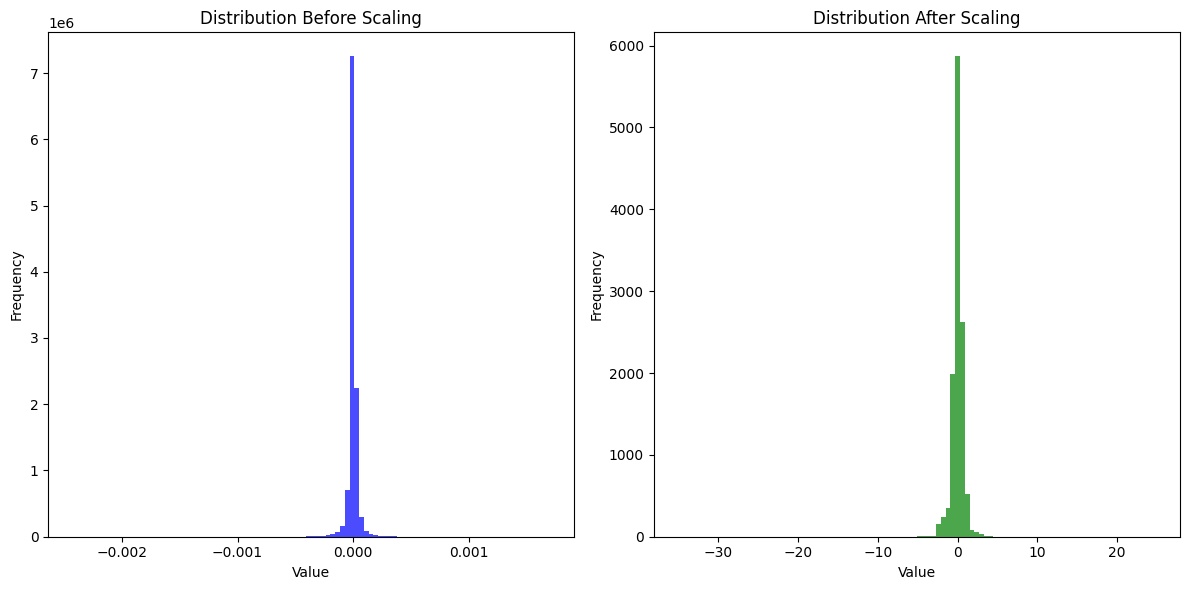

In [62]:
# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(flattened_before, bins=100, color='blue', alpha=0.7)
plt.title('Distribution Before Scaling')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(flattened_after, bins=100, color='green', alpha=0.7)
plt.title('Distribution After Scaling')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Step-3: load models + feature extraction functions

### SVC model with combined features

Here we get the model we previolsly saved. This is the model with both Frequency domain features and time domain features

In [63]:
# Load the SVC model from the file
svc_model = joblib.load('svm_sleep_stage_classifier.pkl')

Then we define same feature extraction functions that we used in project to extract features used to train this model

#### Time domain:

First we define a feature extraction function, this will extract for each EEG signal:
- mean value
- variance
- stardard deviatiation
- energy (rms)

and then concatenates all of those.

In [64]:
def time_domain_features_extractor(X): 
    mean = np.mean(X, axis=-1)              # Mean along time axis
    variance = np.var(X, axis=-1)           # Variance along time axis
    std_dev = np.std(X, axis=-1)            # Standard deviation along time axis
    rms = np.sqrt(np.mean(X**2, axis=-1))   # Root mean square
    
    # Combine features into a single feature vector
    features = np.hstack([mean, variance, std_dev, rms])
    return features

#### Frequency domain:

First (just as before) we define a feature extraction function. This function will extract key metrics like Power Spectral Density (PSD), Band Power:

- **Power Spectral Density (PSD)**: This is because different sleep stages are associated with distinct frequency bands. For example:
    - Delta (0.5-4 Hz): Deep sleep (NREM stages 3-4).
    - Theta (4-8 Hz): Light sleep (NREM stage 1).
    - Alpha (8-13 Hz): Relaxation, often decreases during sleep.
    - Beta (13-30 Hz): Wakefulness or REM sleep.

- **Spectral Entropy**: Indicates the regularity and complexity of the signal in the frequency domain, with lower values during deep sleep stages.

Therefore we could expect big increase in performance by using this kind of features as they are deeply correlated to sleep stages

In [65]:
# Define frequency bands (Hz)
FREQ_BANDS = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30),
}

# Feature extraction function for frequency domain
def frequency_domain_features_extractor(X, sfreq=100):
    # Compute Power Spectral Density (PSD) using Welch's method
    freqs, psd = welch(X, sfreq, nperseg=sfreq)

    # Band Power: Compute power for each frequency band
    band_powers = []
    for band, (low, high) in FREQ_BANDS.items():
        idx_band = (freqs >= low) & (freqs <= high)
        band_power = np.sum(psd[:, idx_band], axis=1)  # Sum power in band
        band_powers.append(band_power)

    # Spectral Entropy: Compute Shannon entropy of the normalized PSD
    psd_normalized = psd / np.sum(psd, axis=1, keepdims=True)  # Normalize PSD
    spectral_entropy = -np.sum(psd_normalized * np.log(psd_normalized + 1e-10), axis=1)

    # Combine features (flatten band powers and append entropy)
    features = np.hstack([np.array(band_powers).flatten(), spectral_entropy])
    return features

#### Combination of features

Merging both feature extractions into one:

In [66]:
# Combine all features into one function
def combine_features_extractor(X, sfreq=100):
    
    frequency_features = frequency_domain_features_extractor(X,sfreq=sfreq)

    time_features = time_domain_features_extractor(X)

    return np.hstack([frequency_features, time_features])

#### Data loader

Calling combined feature extractor in dataloader:

In [67]:
# Function to process dataset and extract nonlinear features
def data_loader_combined_features(dataset):
    features = []
    labels = []
    
    for X, y in dataset:
        features.append(combine_features_extractor(X.numpy().squeeze())) 
        labels.append(y)  # Append label
    
    return np.array(features), np.array(labels)

### Chambon et al model 

In [68]:
class SleepStagerChambon2018(nn.Module):
    """Sleep staging architecture from [1]_.
    
    Convolutional neural network for sleep staging described in [1]_.
    
    Parameters
    ----------
    n_channels : int
        Number of EEG channels.
    sfreq : float
        EEG sampling frequency.
    n_conv_chs : int
        Number of convolutional channels. Set to 8 in [1]_.
    time_conv_size_s : float
        Size of filters in temporal convolution layers, in seconds. Set to 0.5
        in [1]_ (64 samples at sfreq=128).
    max_pool_size_s : float
        Max pooling size, in seconds. Set to 0.125 in [1]_ (16 samples at
        sfreq=128).
    n_classes : int
        Number of classes.
    input_size_s : float
        Size of the input, in seconds.
    dropout : float
        Dropout rate before the output dense layer.
        
    References
    ----------
    .. [1] Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., &
           Gramfort, A. (2018). A deep learning architecture for temporal sleep
           stage classification using multivariate and multimodal time series.
           IEEE Transactions on Neural Systems and Rehabilitation Engineering,
           26(4), 758-769.
    """
    def __init__(self, n_channels, sfreq, n_conv_chs=8, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, n_classes=5, input_size_s=30,
                 dropout=0.25):
        super().__init__()

        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = int(max_pool_size_s * sfreq)
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        len_last_layer = self._len_last_layer(
            n_channels, input_size, max_pool_size, n_conv_chs)

        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(
                n_conv_chs, n_conv_chs, (1, time_conv_size),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(len_last_layer, n_classes)
        )

    @staticmethod
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, x):
        """Forward pass.
        
        Parameters
        ---------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)

        x = self.feature_extractor(x)
        return self.fc(x.flatten(start_dim=1))


In [69]:
# Initialize the model
Chambon_model = SleepStagerChambon2018(n_channels, sfreq, n_classes=5)
# Load the model weights from the file
Chambon_model.load_state_dict(torch.load('sleep_stager_chambon2018.pth'))
# Set the model to evaluation mode
Chambon_model.eval()

C:\Users\admin\AppData\Local\Temp\ipykernel_20884\1573159633.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Chambon_model.load_state_dict(torch.load('sleep_stager_chamb

SleepStagerChambon2018(
  (spatial_conv): Conv2d(1, 4, kernel_size=(4, 1), stride=(1, 1))
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=640, out_features=5, bias=True)
  )
)

#### Data loader

Once again, for this model no real feature extraction is needed. We just need to instantiate the pytorch `DataLoader` (as a pytorch object) that wraps the dataset and makes it easy to obtain batches of examples to feed to our neural network. Therefore this funcion does nothing else than return `identity(ds)` feature extraction of each dataset but sub-divided into batches.

In [70]:
def data_loader_CNN(dataset, valid_batch_size = 256 ):    
    num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

    loader_single_set = DataLoader(dataset, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
    
    return loader_single_set

## Step-4: Live prediction of chosen EEG

### Make predictions for both models:

In [71]:
sample_idx = 0
stages = ["Wake", "NREM1", "NREM2", "NREM3", "REM"]

In [77]:
# Measure prediction time for SVM model
start_time = time.time()
valid_X, valid_y = data_loader_combined_features(dataset=dataset)
predicted_y = svc_model.predict(valid_X)
svm_prediction_time = time.time() - start_time

# Measure prediction time for Chambon et al model
start_time = time.time()
y_pred_all, y_true_all = [], []
test_loader = data_loader_CNN(dataset=dataset)
for batch_x, batch_y in test_loader:
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    output = Chambon_model.forward(batch_x)
    y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
    y_true_all.append(batch_y.cpu().numpy())
y_pred = np.concatenate(y_pred_all)
y_true = np.concatenate(y_true_all)
chambon_prediction_time = time.time() - start_time
rec_ids = np.concatenate(  # indicates which recording each example comes from
    [[i] * len(ds) for i, ds in enumerate(dataset.datasets)])

### Evaluate predictions with accuracy and confusion matrix:

SVM Model Accuracy: 0.80
Chambon et al Model Accuracy: 0.85


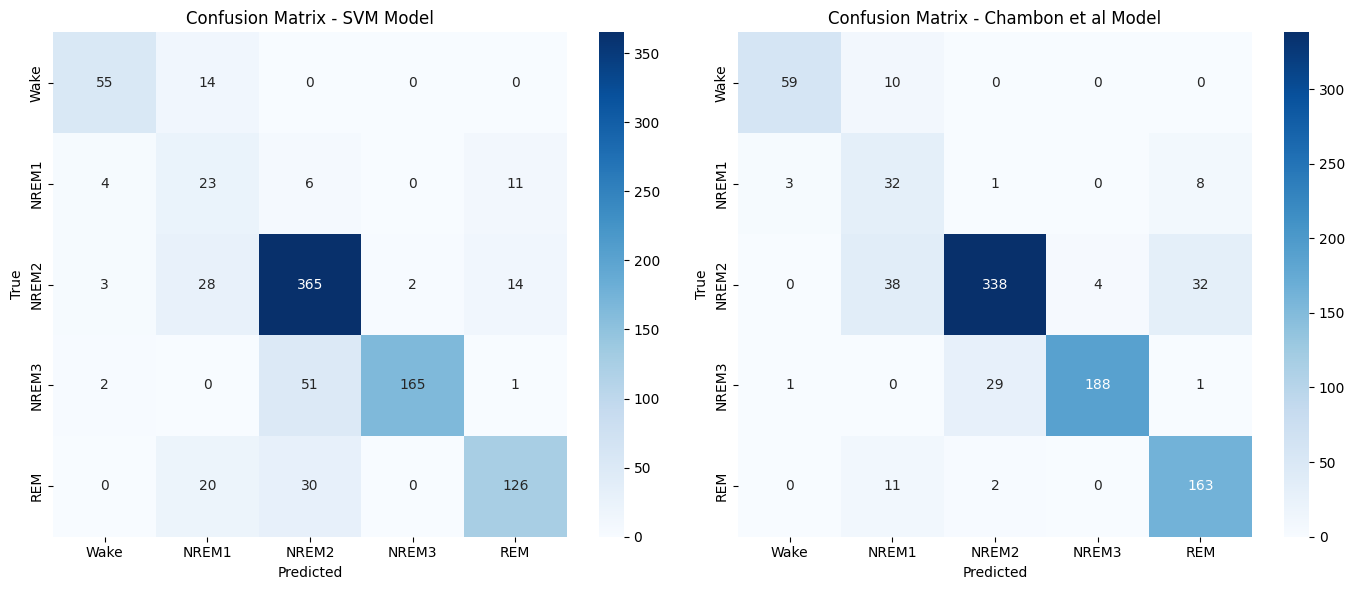

In [78]:
# Calculate accuracy for SVM model
accuracy_svm = accuracy_score(valid_y, predicted_y)
print(f'SVM Model Accuracy: {accuracy_svm:.2f}')

# Calculate accuracy for Chambon et al model
accuracy_chambon = accuracy_score(y_true, y_pred)
print(f'Chambon et al Model Accuracy: {accuracy_chambon:.2f}')

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion matrix for SVM model
cm_svm = confusion_matrix(valid_y, predicted_y)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - SVM Model')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_xticklabels(stages)
axes[0].set_yticklabels(stages)

# Confusion matrix for Chambon et al model
cm_chambon = confusion_matrix(y_true, y_pred)
sns.heatmap(cm_chambon, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Chambon et al Model')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_xticklabels(stages)
axes[1].set_yticklabels(stages)

plt.tight_layout()
plt.show()

### Evaluate prediction time:

SVM Model Prediction Time: 3.28 seconds
Chambon et al Model Prediction Time: 0.97 seconds


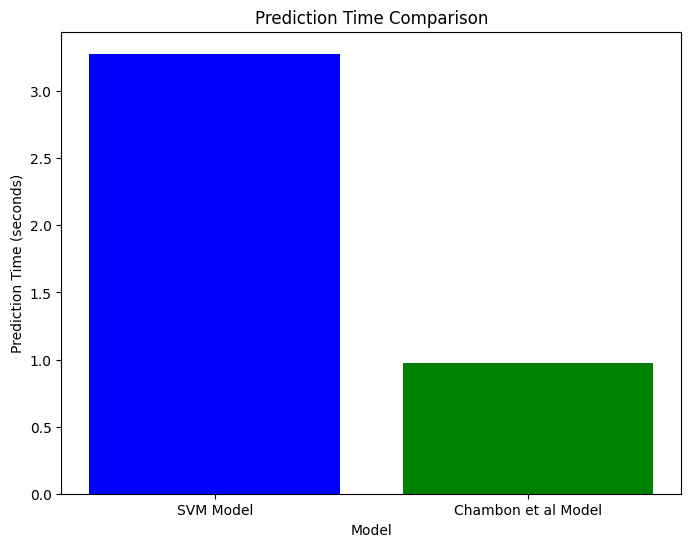

In [79]:
# Print the prediction times
print(f'SVM Model Prediction Time: {svm_prediction_time:.2f} seconds')
print(f'Chambon et al Model Prediction Time: {chambon_prediction_time:.2f} seconds')

# Create a bar chart
models = ['SVM Model', 'Chambon et al Model']
times = [svm_prediction_time, chambon_prediction_time]

plt.figure(figsize=(8, 6))
plt.bar(models, times, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Prediction Time (seconds)')
plt.title('Prediction Time Comparison')
plt.show()

### Show prediction when compared to ground truth:

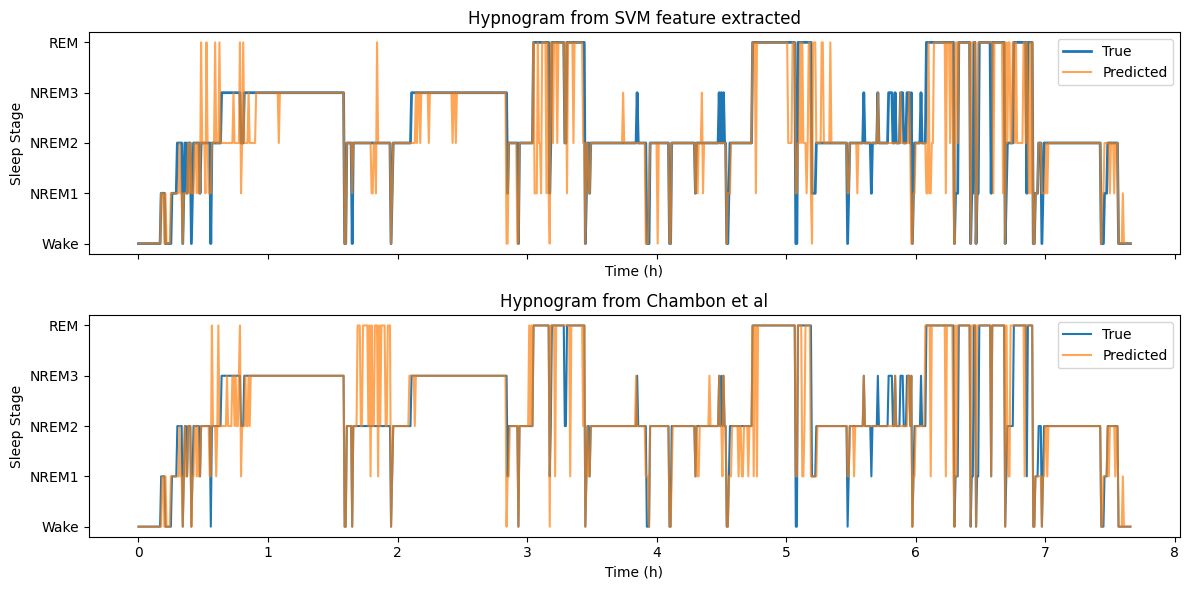

In [73]:
# Create a figure with two subplots (one above the other)
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot 1: Hypnogram from SVM feature extracted
# Create mask for the chosen recording ID
mask = rec_ids == sample_idx
# Create time axis (convert to hours)
t = np.arange(len(valid_y[mask])) * 30 / 3600
# Plot on the first axis
axes[0].plot(t, valid_y[mask], label='True', lw=2)
axes[0].plot(t, predicted_y[mask], alpha=0.7, label='Predicted', lw=1.5)
axes[0].set_yticks([0, 1, 2, 3, 4])
axes[0].set_yticklabels(stages)
axes[0].set_xlabel('Time (h)')
axes[0].set_ylabel('Sleep Stage')
axes[0].set_title(f'Hypnogram from SVM feature extracted')
axes[0].legend()

# Plot 2: Hypnogram for one recording from Chambon et al
t = np.arange(len(y_true[mask])) * 30 / 3600 #valid_y
# Plot on the second axis
axes[1].plot(t, y_true[mask], label='True') #valid_y
axes[1].plot(t, y_pred[mask], alpha=0.7, label='Predicted')
axes[1].set_yticks([0, 1, 2, 3, 4])
axes[1].set_yticklabels(stages)
axes[1].set_xlabel('Time (h)')
axes[1].set_ylabel('Sleep Stage')
axes[1].set_title('Hypnogram from Chambon et al')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

Here we can see hypnograms generated by the both models demonstrates reasonable alignment with the true sleep stages (as we could have guessed by good accuracy results). As we can see both plots look a lot alike, wich further confirm out hypotesis of reaching very similiar classifiers in both attempts. Some of the main differences are:
- SVM model tends to be more precise while classifying REM sleep than Chambon et al; wich makes sense as it should be one of the easyest sleep stages to classify using Power Spectral density
- Chambon et al tends to be more precise when classifying 'wake' sleep stages; wich makes sense again as wakefulness is often characterized by distinct high-frequency brain activity and when we did feature extraction we specifed we didn't add much to classify high frequencies

**Conclusions:**  
By presenting these results, we have demonstrated that with effective feature extraction, even a simple algorithm like SVM can achieve comparable classification performance to highly specialized models, such as Chambon et al.'s approach, which is specifically engineered for sleep classification. This highlights the power of domain knowledge in guiding feature engineering, as well as the efficiency gains that can be achieved by leveraging simpler, classical machine learning techniques.  

One of the key advantages of this approach is the significant reduction in computational cost and training time. Specifically:  
- **Efficiency of Simpler Models**: Using a simple model like SVM with manually extracted features required only 1-2 seconds in total for feature extraction and training. This makes it highly practical for resource-constrained settings where computational power or time is limited.  
- **Higher Computational Costs for End-to-End Models**: Although Chambon et al.'s model eliminates the need for manual feature extraction and works directly with raw data, it required approximately 20 minutes to train. This significant time difference stems from the complexity of deep learning architectures, which rely on iterative optimization and the processing of raw, high-dimensional data.  

These findings highlight a crucial trade-off: while deep learning models like Chambon et al.'s are powerful and capable of directly extracting features from raw data, they demand more computational resources and time. On the other hand, classical models, when combined with carefully crafted feature engineering, can deliver competitive performance with minimal resource requirements.  

This has practical implications for real-world applications:  
- For tasks requiring rapid prototyping or deployment in low-resource environments, feature-based classical models are highly advantageous.  
- For high-stakes or large-scale tasks where accuracy outweighs computational cost, end-to-end deep learning models might be more suitable.  

Ultimately, the results underscore the value of balancing model complexity with problem requirements and resource availability, making both approaches viable depending on the use case.  